Data preparation 

In [112]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score, roc_curve

from keras import backend as K
from keras import Sequential, Model
from keras.layers import BatchNormalization, Dense, Flatten, Conv2D, MaxPooling2D



np.random.seed(2002)

In [15]:
#Loading the data 
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [16]:
#splitting the labels from the train data

x_train = train.drop(columns=['label']).values
y_train = train['label'].values

x_test = test.values

In [17]:
x_train.shape

(42000, 784)

In [18]:
train.isna().sum().sum()

0

In [19]:
unique_classes = np.unique(y_train)
num_classes = len(unique_classes)
print(num_classes)

10


In [20]:
#Reshaping data to 28x28 pixel image
print("Original x_train shape:", x_train.shape)
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)
print("Reshaped x_train shape:", x_train.shape)

#normalising pixel values
X_train = x_train.astype('float32') / 255.0
X_test = x_test.astype('float32') / 255.0



Original x_train shape: (42000, 784)
Reshaped x_train shape: (42000, 28, 28, 1)


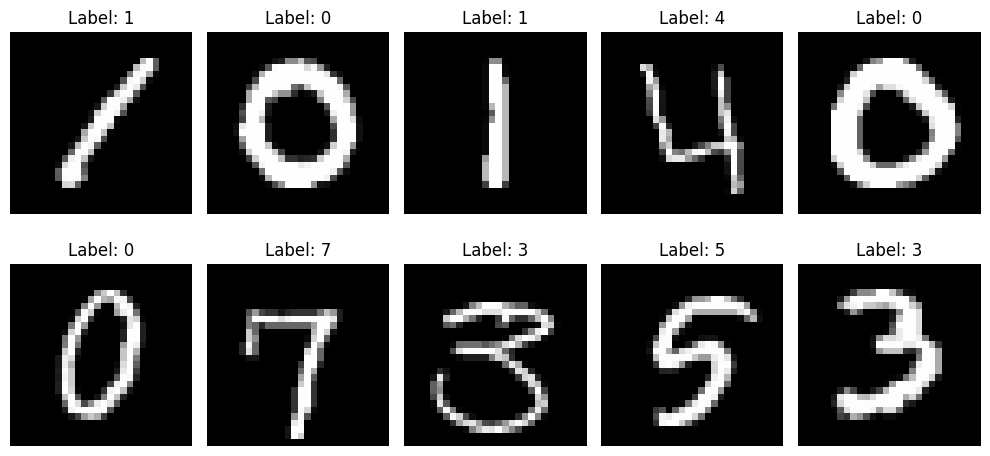

In [21]:
def display_images(images, labels, num=10):
    plt.figure(figsize=(10, 5))
    for i in range(num):
        plt.subplot(2, 5, i + 1)  # Create a grid of 2 rows and 5 columns
        plt.imshow(x_train[i], cmap='gray')  # Reshape for display
        plt.title(f'Label: {y_train[i]}')
        plt.grid(False)
        plt.axis('off')  # Hide axis
    plt.tight_layout()
    plt.show()

# Display the first 10 images and their labels
display_images(x_train, y_train, num=10)

In [22]:
#converting labels to categorical format
y_train = to_categorical(y_train, num_classes= 10)

In [48]:
input_layer = layers.Input(shape=(28, 28, 1))

# Add convolutional layers with pooling and batch normalization
x = Conv2D(32, (5, 5), activation='relu', padding='Same')(input_layer)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='Same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='Same')(x)
x = BatchNormalization()(x)

# Flatten the output
x = Flatten()(x)

# Add dense layers after flattening
x = Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
prediction_layer = Dense(10, activation='softmax')(x)

# Creating the final model using the input and output layers
cnn_model = Model(inputs=input_layer, outputs=prediction_layer)

# Compile the model
cnn_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
cnn_model.summary()


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 459,722 (1.75 MB)

 Trainable params: 459,402 (1.75 MB)

 Non-trainable params: 320 (1.25 KB)

In [103]:
history = cnn_model.fit(X_train, y_train, epochs= 32, batch_size= 32, validation_split= 0.2)

Epoch 1/32
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9982 - loss: 0.0067 - val_accuracy: 0.9904 - val_loss: 0.0844
Epoch 2/32
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9989 - loss: 0.0039 - val_accuracy: 0.9908 - val_loss: 0.0766
Epoch 3/32
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9987 - loss: 0.0046 - val_accuracy: 0.9904 - val_loss: 0.0850
Epoch 4/32
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - accuracy: 0.9991 - loss: 0.0023 - val_accuracy: 0.9906 - val_loss: 0.0792
Epoch 5/32
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9993 - loss: 0.0028 - val_accuracy: 0.9894 - val_loss: 0.0951
Epoch 6/32
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9995 - loss: 0.0015 - val_accuracy: 0.9898 - val_loss: 0.1007
Epoch 7/32
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9996 - loss: 0.0021 - val_accuracy: 0.9907 - val_loss: 0.0900
Epoch 8/32
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9997 -

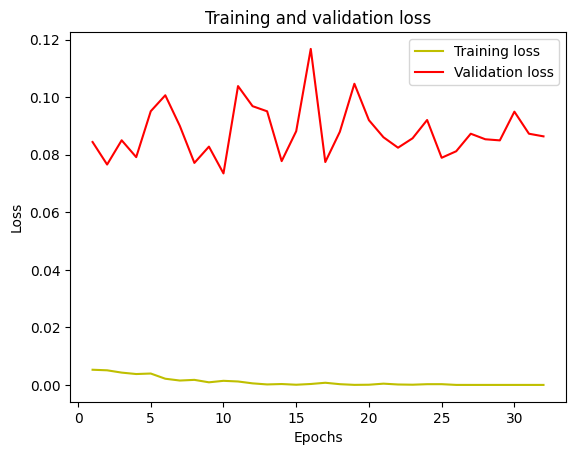

In [104]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

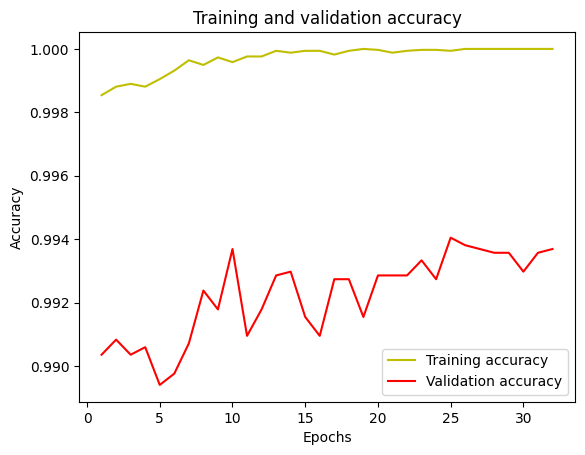

In [105]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [106]:
x_train_rf = cnn_model.predict(X_train)
x_test_rf = cnn_model.predict(X_test)

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


In [107]:
print(x_train_rf)

[[8.0788898e-34 1.0000000e+00 6.1079838e-31 ... 1.2522547e-37
  4.1983773e-34 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 4.1165415e-36 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [1.7337485e-37 1.0000000e+00 5.2602036e-34 ... 0.0000000e+00
  2.9953279e-30 0.0000000e+00]
 ...
 [1.5915078e-26 6.8507723e-32 1.0209043e-27 ... 1.0000000e+00
  8.5526912e-34 1.8334589e-24]
 [5.8601217e-36 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [2.0397456e-24 3.7329340e-33 1.6033451e-22 ... 3.6667399e-19
  4.1483587e-18 1.0000000e+00]]


In [113]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(x_train_rf, y_train)

print("Best parameters found: ", grid_search.best_params_)

c:\Users\haris\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
324 fits failed out of a total of 972.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
324 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\haris\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\haris\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\haris\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base

Best parameters found:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}


In [114]:
best_params = grid_search.best_params_

In [121]:
RF = RandomForestClassifier(n_estimators= 100, random_state=42)

RF.fit(x_train_rf, y_train)

test_pred = RF.predict(x_test_rf)

In [122]:
y_train_classes = np.argmax(y_train, axis=1)
print("Unique classes in y_train_classes:", np.unique(y_train_classes))

Unique classes in y_train_classes: [0 1 2 3 4 5 6 7 8 9]


In [123]:
train_predictions = RF.predict(x_train_rf)
train_predictions = np.argmax(train_predictions, axis=1)
print("Random Forest Accuracy on Train Data:", accuracy_score(y_train_classes, train_predictions))

# Confusion matrix
print(confusion_matrix(y_train_classes, train_predictions))

Random Forest Accuracy on Train Data: 0.9996666666666667
[[4131    0    1    0    0    0    0    0    0    0]
 [   0 4683    1    0    0    0    0    0    0    0]
 [   0    0 4175    0    0    0    0    1    1    0]
 [   0    0    0 4350    0    0    0    0    0    1]
 [   0    1    0    0 4070    0    0    0    0    1]
 [   0    0    0    0    0 3795    0    0    0    0]
 [   0    0    0    0    0    0 4137    0    0    0]
 [   0    0    0    0    0    0    0 4400    1    0]
 [   0    0    0    0    0    0    0    0 4062    1]
 [   3    0    0    0    1    0    0    1    0 4183]]


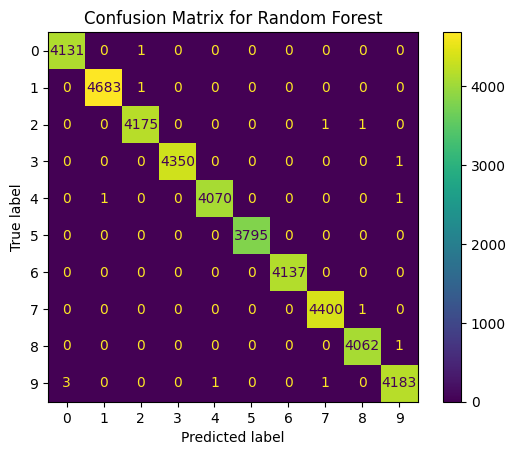

In [124]:
ConfusionMatrixDisplay.from_predictions(y_train_classes, train_predictions)
plt.title('Confusion Matrix for Random Forest')
plt.show()

In [125]:
test_pred_labels = np.argmax(test_pred, axis=1)
image_id = np.arange(1, len(test_pred) + 1)  # Create ImageId from 1 to 28000

# Create a DataFrame for submission
submission_df = pd.DataFrame({
    'ImageId': image_id,
    'Label': test_pred_labels
})

# Save the DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)

print("Submission file 'submission.csv' has been created successfully.")

Submission file 'submission.csv' has been created successfully.
